# Lab2 - Concrete compressive strength regression (35 marks total)
Author: Steven Duong (30022492)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Function definitions (2 marks)

To find the best model, we follow the published article where root-mean squared error (rms) was used as a score function. The rms score function needs to be minimized, because the optimal score is 0, larger values are worse performances

In scikit-learn, only *maximization* is implemented. Hence, it is customary to maximize the *negative* rms. scitkit-learn provides a scoring function `neg_root_mean_squared_error`

In [11]:
from sklearn.model_selection import cross_validate


def get_regressor_neg_rms(model, X, y, cv=7):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms)
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    
    scoring = ['neg_root_mean_squared_error']
    score_cv = cross_validate(estimator=model, X=X, y=y, cv=cv, scoring=scoring, return_train_score=True)

    mean_train = score_cv['train_' + scoring[0]].mean()
    mean_test = score_cv['test_' + scoring[0]].mean()

    return (mean_train, mean_test)
    

## 1. Load data (1 mark each for 3 total marks)
yellowbrick concrete  
https://www.scikit-yb.org/en/latest/api/datasets/concrete.html

Load the Dataset object with `load_concrete()` using `return_dataset=True`

Print the README of the Dataset object


In [12]:
from yellowbrick.datasets.loaders import load_concrete

# Load concrete dataset
concrete_data = load_concrete(return_dataset=True)

# Printing the README of the Dataset object
print(concrete_data.README)


# Concrete Compressive Strength

**Downloaded from the UCI Machine Learning Repository on October 13, 2016.**

- Multivariate Data Set
- Real Attributes
- 1,030 Instances
- 9 attributes
- Well suited for _regression_ tasks
- [https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

## Abstract

Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients.

## Description

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the regression problem. The order of this listing corresponds to the order of numerals along the rows of the database.

## Attributes

- cement (kg)
- blast furnace slag (kg)
- fly ash (kg)
- water (kg)
- superplasticizer (kg)
- coarse aggregate (kg)
- fine aggregate (kg)
- age (day)
- compressive strength (MPa)

## Citat

### *Question 1:* What is the target variable name and units in this dataset?

The target variable name is **concrete compressive strength** and the unit is **MPA**.


### 1.1 Prepare the feature matrix and target vector
Load the concrete data set into feature matrix `X` and target vector `y`

Print dimensions and type of `X`, `y`

In [13]:
# Load concrete dataset into feature matrix X and target vector y
X, y = concrete_data.to_data()

# Printing the dimensions and type of X and y
print(f"Dimensions of X:\n{X.shape}\nType of X:\n{type(X)}")
print(f"\nDimensions of y:\n{y.shape}\nType of y:\n{type(y)}")


Dimensions of X:
(1030, 8)
Type of X:
<class 'pandas.core.frame.DataFrame'>

Dimensions of y:
(1030,)
Type of y:
<class 'pandas.core.series.Series'>


## 2. Inspect the data (1 mark each for 4 total marks)

### 2.1 Range of each feature
To get an idea if the features are on the same scale, we inspect the range of features

Print the minimum and maximum of each feature in `X`

In [14]:
# Aggregating the data and printing the min and max of each feature.
# Transposing the table for better visualization.
X.aggregate(['min', 'max']).T


,min,max
cement,102.00,540.0
slag,0.00,359.4
ash,0.00,200.1
water,121.75,247.0
splast,0.00,32.2
coarse,801.00,1145.0
fine,594.00,992.6
age,1.00,365.0


### 2.2 Boxplot of features 
Using seaborn boxplot, plot all features. This provides a visual view of feature ranges

Add y-axis label indicating units, and a title

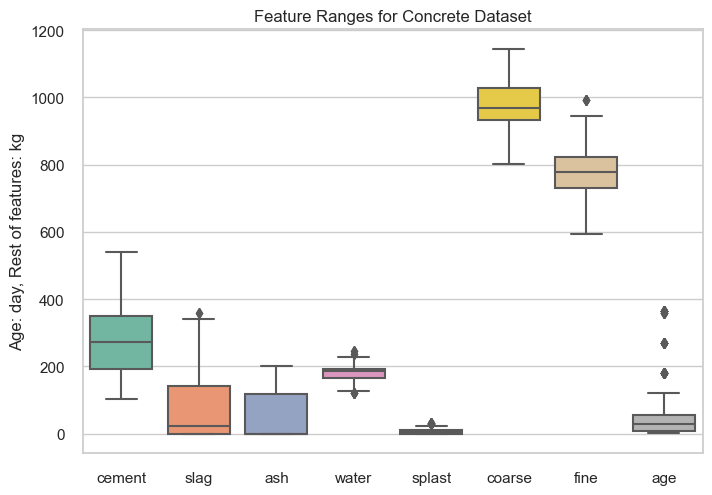

In [15]:
# Plotting using seaborn boxplot
import seaborn as sns

# Create a boxplot for each feature
sns.set(style="whitegrid")
ax = sns.boxplot(data=X, orient="v", palette="Set2")
ax.set_ylabel("Age: day, Rest of features: kg")
ax.set_title("Feature Ranges for Concrete Dataset");


### 2.3 Correlation heatmap of features 

To understand if pairs of features are potentially related, contain similar information, pair-wise cross-correlation can be calculated. Models benefit most from un-correlated features.

Using pandas `corr()` method, create the cross-correlations between all features. Plot this cross-correlation object using seaborn `heatmap()` with parameters `vmin=-1, vmax=1, annot=True, cmap='BrBG'`. Add a title.

Pandas `corr()` calculates [Pearson correlation ](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) :
>  It has a value between +1 and −1. A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

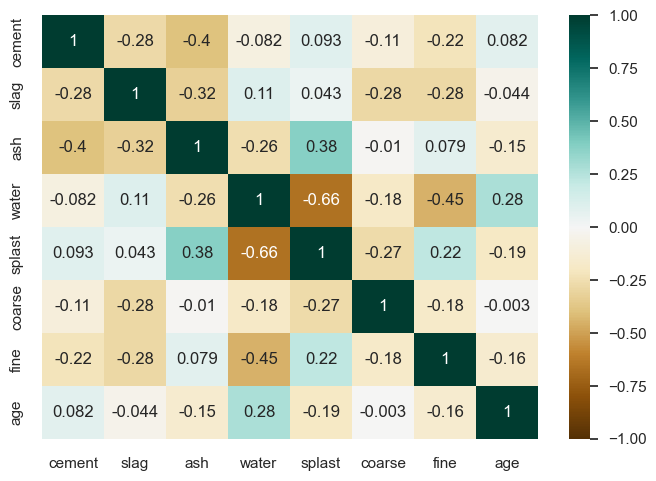

In [16]:
# Creating pairwise cross-correlation heatmap of features
X_corr = X.corr()

# Plotting the heatmap
sns.heatmap(data=X_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG');

### 2.4 Histogram of target variable 

To understand if all target values are equally represented in the data, we analyze how many samples of each target value we have available. The histogram of the target vector can visualize this distribution.

Using seaborn `displot()`, plot the histogram of the target vector. Add a title.

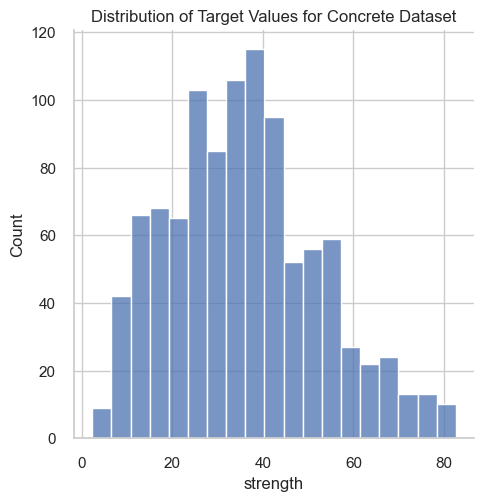

In [17]:
import matplotlib.pyplot as plt

# Plotting the histogram of the target vector
sns.displot(data=y)

# Adding the title
plt.title("Distribution of Target Values for Concrete Dataset");


## 3. Create training and test sets (1 mark)

Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X` and `y` into training and test sets

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Splitting the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, test_size=0.2)


## 4. Compare models using cross-validation (3 marks)

Create a list containing a `LinearRegression()`, `RandomForestRegressor(random_state=64)` and `GradientBoostingRegressor(random_state=79)` objects.

Iterate this list and:
- using `X_train` and `y_train`
- compute the negative root mean-squared error using the `get_regressor_neg_rms()` function
- and print the training and validation scores with **2 decimal places**
- Use 7-fold cross-validation

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [21]:
# List of regression models
regression_models = [LinearRegression(), RandomForestRegressor(random_state=64), GradientBoostingRegressor(random_state=79)]

# Iterating the list of regression models
for model in regression_models:

  # Printing regression model label
  print(f"{model.__class__.__name__} model")

  # Calculating the training and test scores
  train_score, test_score = get_regressor_neg_rms(model, X_train, y_train, 7)

  # Printing the scores
  print(" 1. RMSE Training Score: {0:.2f}".format(train_score))
  print(" 2. RMSE Validation Score: {0:.2f}\n".format(test_score))


LinearRegression model
 1. RMSE Training Score: -10.29
 2. RMSE Validation Score: -10.39

RandomForestRegressor model
 1. RMSE Training Score: -2.12
 2. RMSE Validation Score: -4.97

GradientBoostingRegressor model
 1. RMSE Training Score: -3.69
 2. RMSE Validation Score: -4.98



### *Question 2:* For each of the three models, state if models are potentially over- or underfitting and why (3 marks)

1. **Linear Regression:** The model is potentially underfitting. This is due to the training and validation RMSE scores being very high (in negative terms). This means that the model complexity is low with high bias.

2. **RandomForestRegressor:** The model is potentially overfitting. This is due to the training RMSE score being noticeably better than the RMSE validation score with a high variance.

3. **GradientBoostingRegressor:** The model is potentially overfitting. This is due to the RMSE training score being lower than the validation RMSE score with a high variance.


## 5. Find a better model (3 marks)

Use the `RandomForestRegressor(random_state=64)` and find the best combination of `max_depth` from the list of `[10, 15, 20]`, and `n_estimators` from the list of `[100, 200, 400]`

Use nested for-loops to iterate these two lists:
- using `X_train` and `y_train`
- compute the negative root mean-squared error of the corresponding `RandomForestRegressor(random_state=64)` using the `get_regressor_neg_rms()` function 
- and print the training and validation scores with **2 decimal places**
- Use 7-fold cross-validation

Report the best validation score and the corresponding model

Note: We expect that more trees (larger `n_estimators`) yield better model performance

In [22]:
import pandas as pd

# List of hyperparameter values
max_depth = [10, 15, 20]
n_estimators = [100, 200, 400]

# Create an empty list to hold the results
results = []

for m in max_depth:
    for n in n_estimators:

        # Creating random forest regressor
        rfr = RandomForestRegressor(n_estimators=n, max_depth=m, random_state=64)

        # negative RMSE scores
        train_score, test_score = get_regressor_neg_rms(rfr, X_train, y_train, 7)

        # Add the results to the list as a dictionary
        results.append({"max_depth": m, "n_estimators": n, "train_score": train_score, "test_score": test_score})

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(results)

# Format the train_score and test_score columns to 2 decimal places
df["train_score"] = df["train_score"].round(2)
df["test_score"] = df["test_score"].round(2)

# Print the DataFrame
print(df)

   max_depth  n_estimators  train_score  test_score
0         10           100        -2.44       -5.09
1         10           200        -2.42       -5.06
2         10           400        -2.41       -5.06
3         15           100        -2.12       -4.97
4         15           200        -2.11       -4.93
5         15           400        -2.10       -4.93
6         20           100        -2.12       -4.97
7         20           200        -2.11       -4.93
8         20           400        -2.09       -4.92


### *Question 3:* Which combination of `max_depth` and `n_estimators` produced the best validation score? Report both training and validation scores here (2 marks)

The following combinaion of max_depth and n_estimators procduced the best validaiton score:

**max_depth:** 20\
**n_estimators:** 400


## 6. Retrain best model (2 marks)

Create a `RandomForestRegressor(random_state=64)` with the best pair of `max_depth` and `n_estimators`, and retrain this model on all training data.

In [23]:
# Creating a new model with the best pair of hyperparameters
model = RandomForestRegressor(random_state=64, max_depth=20, n_estimators=400)

# Fitting the model on the training data
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=400, random_state=64)

## 7. Evaluate best model on training and test data
### 7.1 Root mean-squared error and $R^2$ (3 marks)

For the retrained best estimator, print the root mean-squared error (**2 decimal places**) and R-squared (**3 decimal places**) for training and test sets.

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
import numpy as np

# Predicting the data on the training set
y_train_pred = model.predict(X_train)

# Obtain training rms
rms_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Obtain training r2
r2_train = r2_score(y_train, y_train_pred)

# Predicting the data on the validation set
y_test_pred = model.predict(X_test)

# Obtain testing rms
rms_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Obtain testing r2
r2_test = r2_score(y_test, y_test_pred)

# Printing the rms and r-squared values
print("Training Set:\nRoot mean-squared error = {0:.2f} MPa\nR-squared = {1:.3f}".format(rms_train, r2_train))
print("\nTest Set:\nRoot mean-squared error = {0:.2f} MPa\nR-squared = {1:.3f}".format(rms_test, r2_test))


Training Set:
Root mean-squared error = 2.00 MPa
R-squared = 0.986

Test Set:
Root mean-squared error = 4.80 MPa
R-squared = 0.915


### *Question 4:* How does this test score compare to the polynomial regression and neural network reported in the article? Do we outperform the reported models? Include scores in your answer. (2 marks)

This model outperforms the polynomial regression with a lower RMS error and a R2 value that is closer to 1 for the testing data.

This model falls behind the neural network since the testing data in the neural network has a lower RMSE and R2 value that is closer to 1.

### 7.2 Predicted vs actual strength plot (1 mark)
Using a scatterplot, show predicted strength on the x axis and actual strength on the y axis with data from the test set. With this plot, we can see where we make errors.

Add a line of unity (diagonal with slope 1 and offset 0). Ideally, all points would be on this line. We look for points being distributed equally around the line of unity.

Add x-axis, y-axis labels including units, and a title.


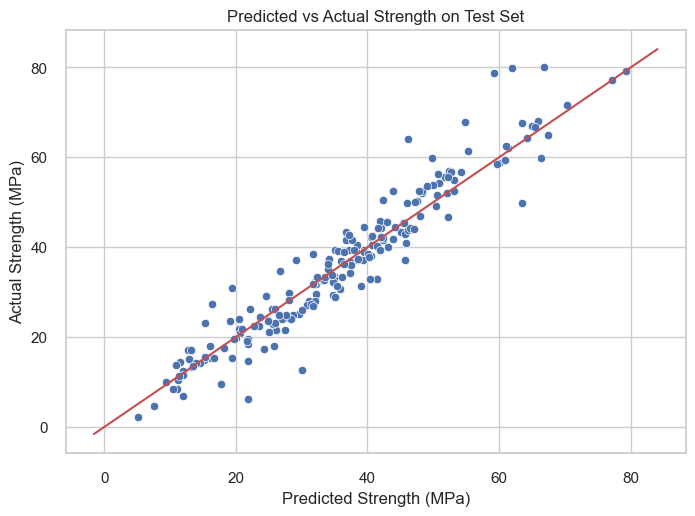

In [26]:
# Create scatter plot of predicted strength versus actual strength
sns.scatterplot(x=y_test_pred, y=y_test)

# Add line of unity
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
minval = min(xmin, ymin)
maxval = max(xmax, ymax)
plt.plot([minval, maxval], [minval, maxval], 'r')

# Add axis labels and title
plt.xlabel("Predicted Strength (MPa)")
plt.ylabel("Actual Strength (MPa)")
plt.title("Predicted vs Actual Strength on Test Set")

# Show the plot
plt.show()


### 7.3 Residual plot (1 mark)
Using a scatterplot, show predicted strength on the x axis and the *difference* between actual and predicted strength on the y axis with data from the test set. This is an alternative way to see where errors are made.

We look for residuals being distributed equally around the zero horizontal line.

Add x-axis, y-axis labels including units, and a title.



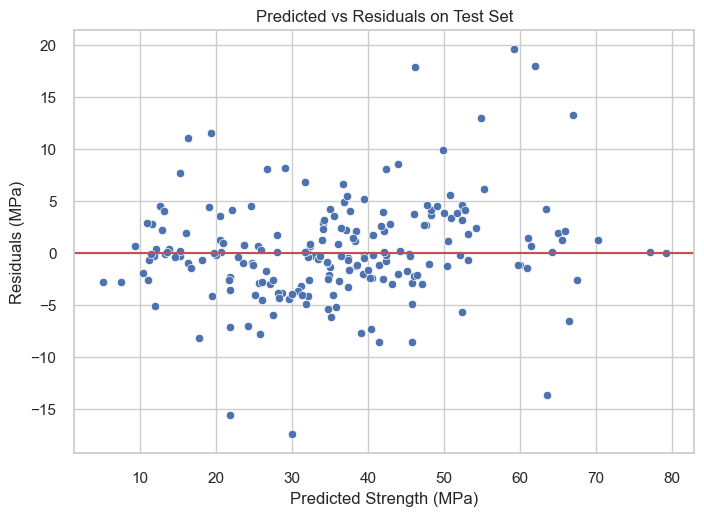

In [27]:
import matplotlib.pyplot as plt

# Predicting the data on the test set
y_test_pred = model.predict(X_test)

# Calculate the residuals
residuals = y_test - y_test_pred

# Create scatter plot of predicted strength versus residuals
sns.scatterplot(x=y_test_pred, y=residuals)

# Add a horizontal line at y = 0
plt.axhline(0, color='r')

# Add axis labels and title
plt.xlabel("Predicted Strength (MPa)")
plt.ylabel("Residuals (MPa)")
plt.title("Predicted vs Residuals on Test Set")

# Show the plot
plt.show()


## 8. Conclusion (3 marks)

In conclusion, comment on the following items:
1. Did we find a model that outperforms the polynomial regression reported in the reference article? Explain.
1. Did we find a model that outperforms the neural network reported in the reference article? Explain.
1. What were our assumption about the dataset and train/test split? How do these assumptions affect your conclusions?


1. Yes, the RandomForestRegressor model with max_depth = 20 and n_estimators = 400 outperformed the polynomial regression. The testing RMSE of our model is 4.80 MPa, which is much lower than polynomial regression's RMSE at 8.82 MPa. The R2 value of our model is also closer to 1 with a value of 0.915 vs. 0.791 for polynomial regression.

2. No, the RandomForestRegressor model with max_depth = 20 and n_estimators = 400 did not outperform the neural network reported in the reference article. Our model has a RSME of 4.80 MPa, which is higher than the testing RMSE of the neural network (4.32 MPa). In addition, the neural network had an R2 value of 0.929, which is closer to 1 versus 0.915.

3. We made the assumption that the yellowbrick dataset was used in the reference article, we also assumed that 20% of our dataset was used as the test set. As a result of the 20% split, the model performance is susceptible to bias, which is why cross-validation is important. Furthermore, if the results of the study had been carried out on a different dataset, the conclusions made in this lab would have been different as their results can not be directly compared to ours.

## 9. Reflection (2 marks)



Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challenging, motivating while working on this assignment.

I particularly found the use of visualization tools such as Seaborn and Yellowbrick interesting, as they helped to gain insights into the data and the performance of the models. I also enjoyed working with the Random Forest model and experimenting with different hyperparameters to see how they affect the model's performance.

The challenge of implementing the get_regressor_neg_rms() function to compute negative RMSE scores was also interesting, as it helped to understand the importance of scoring functions in evaluating model performance. Overall, this assignment provides a comprehensive introduction to building and evaluating machine learning models using Python and Scikit-learn, and I found it both challenging and motivating.

# Appendix-A: Bonus - use grid search to find the best model parameters
### (5 potential bonus marks)

## A-0. Workflow overview

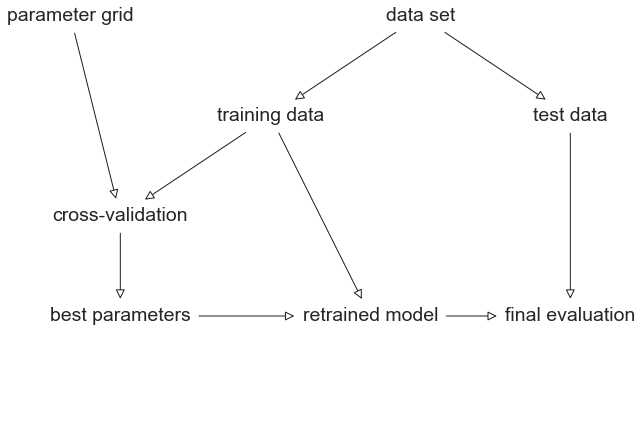

In [28]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## A-1. Hyperparameter tuning using grid search (2 marks)

The inital cross-validation above showed that both DecisionTree based models might have merit. Next, the hyperparameters are tuned using grid search.

### A-1.1 Grid search for RandomForestRegressor

Perform grid search using `GridSearchCV` for the `RandomForestRegressor(random_state=64)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 400]`
- `'max_depth': [ 15, 17, 19, 21]`
- `'max_features': ['auto', 'log2', None]`


In [29]:
from sklearn.model_selection import GridSearchCV

# Creating the parameter grid
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [ 15, 17, 19, 21],
    'max_features': ['auto', 'log2', None]
}

# Setting up the grid search
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=64), param_grid, cv=7, scoring='neg_root_mean_squared_error')


In [30]:
# Performing the grid search with fit()
grid_rfr.fit(X_train, y_train)


GridSearchCV(cv=7, estimator=RandomForestRegressor(random_state=64),
             param_grid={'max_depth': [15, 17, 19, 21],
                         'max_features': ['auto', 'log2', None],
                         'n_estimators': [100, 200, 400]},
             scoring='neg_root_mean_squared_error')

In [33]:
# Printing the best parameters
print("Best parameters found by grid search:", grid_rfr.best_params_)


Best parameters found by grid search: {'max_depth': 19, 'max_features': 'log2', 'n_estimators': 400}


In [36]:
# Printing the best score
print("Best score found by grid search:", grid_rfr.best_score_)


Best score found by grid search: -4.890123611074559


### A-1.2 Grid search for gradient boosted tree

Perform grid search using `GridSearchCV` for the `GradientBoostingRegressor(random_state=79)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 500]`
- `'max_depth': [1, 3, 5, 7]`
- `'learning_rate': [0.01, 0.1, 1.0]`

In [38]:
from sklearn.model_selection import GridSearchCV

# Creating the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [1, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Setting up the grid search
grid_gbr = GridSearchCV(GradientBoostingRegressor(random_state=79), param_grid, cv=7, scoring='neg_root_mean_squared_error')


In [39]:
# Performing the grid search by calling fit()
grid_gbr = grid_gbr.fit(X_train, y_train)


In [40]:
# Printing the best parameters
print("Best parameters found by grid search:", grid_gbr.best_params_)


Best parameters found by grid search: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


In [41]:
# Printing the best score
print("Best score found by grid search:", grid_gbr.best_score_)


Best score found by grid search: -4.207707066815203


### *Question A-1:* Which of the two models produces the best score? What is the best score?

GradientBoostingRegressor produces the best score with a score of -4.20771

## A-2. Retrain best model (1 mark)

Get the best estimator from the two grid searches above and retrain this model on all training data.

In [42]:
# Retraining the model with the best estimator
model = grid_gbr.best_estimator_

# Fitting the model with the training data
model.fit(X_train, y_train)


GradientBoostingRegressor(n_estimators=500, random_state=79)

## A-3. Model evaluation and conclusion (1 mark)

Repeat steps in Section 7 above for the best model.

Revisit your Question 4.

In [43]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predicting the data on the training set
y_train_pred = model.predict(X_train)

# Obtain training rms
rms_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Obtain training r2
r2_train = r2_score(y_train, y_train_pred)

# Predicting the data on the validation set
y_test_pred = model.predict(X_test)

# Obtain testing rms
rms_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Obtain testing r2
r2_test = r2_score(y_test, y_test_pred)

# Printing the rms and r-squared values
print("Training Set:\nRoot mean-squared error = {0:.2f} MPa\nR-squared = {1:.3f}".format(rms_train, r2_train))
print("\nTest Set:\nRoot mean-squared error = {0:.2f} MPa\nR-squared = {1:.3f}".format(rms_test, r2_test))


Training Set:
Root mean-squared error = 2.07 MPa
R-squared = 0.985

Test Set:
Root mean-squared error = 4.51 MPa
R-squared = 0.926


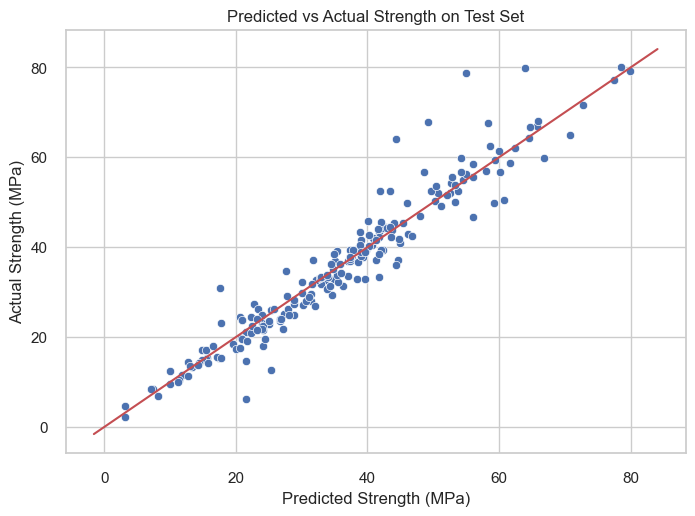

In [44]:
# Create scatter plot of predicted strength versus actual strength
sns.scatterplot(x=y_test_pred, y=y_test)

# Add line of unity
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
minval = min(xmin, ymin)
maxval = max(xmax, ymax)
plt.plot([minval, maxval], [minval, maxval], 'r')

# Add axis labels and title
plt.xlabel("Predicted Strength (MPa)")
plt.ylabel("Actual Strength (MPa)")
plt.title("Predicted vs Actual Strength on Test Set")

# Show the plot
plt.show()


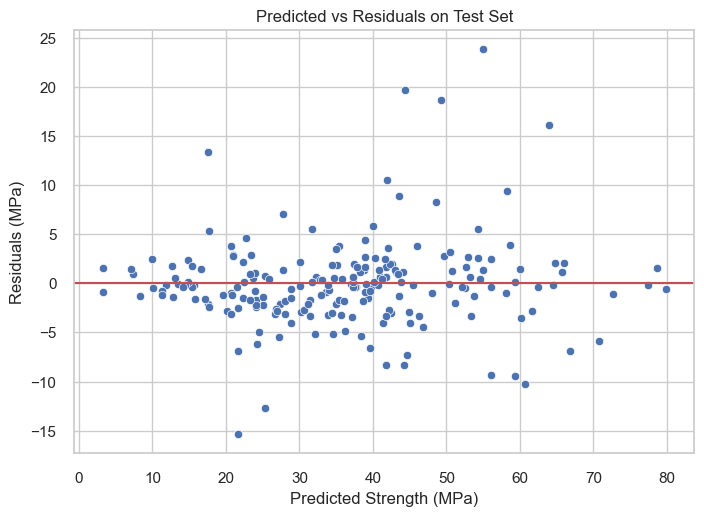

In [45]:
import matplotlib.pyplot as plt

# Predicting the data on the test set
y_test_pred = model.predict(X_test)

# Calculate the residuals
residuals = y_test - y_test_pred

# Create scatter plot of predicted strength versus residuals
sns.scatterplot(x=y_test_pred, y=residuals)

# Add a horizontal line at y = 0
plt.axhline(0, color='r')

# Add axis labels and title
plt.xlabel("Predicted Strength (MPa)")
plt.ylabel("Residuals (MPa)")
plt.title("Predicted vs Residuals on Test Set")

# Show the plot
plt.show()


### *Question A-4:* How does this test score compare to the polynomial regression and neural network reported in the article? Do we outperform the reported models? (1 mark)

The GradientBoostedRegressor with hyperparameter tuning (learning_rate=0.1, max_depth=3, n_estimators=500) outperforms the polynomial regression reported in the article. The RMS in our model is 4.51 MPa, which is lower than the polynomial regression RMS of 8.82 MPa.

However, the GBR with hyperparameter tuning does not outperform the neural network with an RMS of 4.32 MPa, versus 4.51 MPa in our model.